In [ ]:
#Model 3 refers to the efficient CNN, which can be found at:
#https://github.com/hellojialee/Traffic_Sign_Recognition_Efficient_CNNs

#Check GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

#GPU count and name
!nvidia-smi -L

Found GPU at: /device:GPU:0
GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-52acf039-fa03-a092-deee-f0b741d86653)


In [ ]:
#mount google drive where dataset is saved
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#Copy gdrive file to local folder. This reduces latency a lot!
!mkdir train_local
!cp /content/gdrive/MyDrive/GTSRB/gtsrb.zip /content/train_local

In [1]:
#unzip dataset
!unzip -u "/content/train_local/gtsrb.zip" -d "/content/train_local"

unzip:  cannot find or open /content/train_local/gtsrb.zip, /content/train_local/gtsrb.zip.zip or /content/train_local/gtsrb.zip.ZIP.


In [ ]:
#Import libraries and dependencies
!pip install tf-explain
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 1.1MB 12.9MB/s 
     |████████████████████████████████| 3.4MB 31.1MB/s 
     |████████████████████████████████| 25.3MB 127kB/s 
  Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, concatenate, BatchNormalization, MaxPool2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.metrics import CategoricalAccuracy

#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import time
import pickle

from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import SaliencyMapMethod
from art.attacks.evasion import DeepFool
from art.estimators.classification import TensorFlowV2Classifier
from tensorflow.keras.losses import CategoricalCrossentropy

from tf_explain.core.grad_cam import GradCAM

In [ ]:
#Specify the path to training folder and generating the label of training data
train_dir = '/content/train_local/Train/' # Change the path relative to your computer
classes = [str(x) for x in np.linspace(0,43,43).astype(int)]

In [ ]:
#Generate training and validation data with image generator
def image_generator(train_parent_directory):
    
    train_datagen = ImageDataGenerator(rescale=1/255, validation_split = 0.2)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                  target_size = (30,30),
                                  batch_size = 100,
                                  class_mode = 'categorical',
                                  classes = classes,
                                  subset='training')
 
 
    val_generator = train_datagen.flow_from_directory(train_parent_directory,
                                 target_size=(30,30),
                                 batch_size = 25,
                                 class_mode = 'categorical',
                                 classes = classes,
                                 subset='validation')    
  
    
    return train_generator, val_generator

train_generator, val_generator = image_generator(train_dir)

Found 31176 images belonging to 43 classes.
Found 7793 images belonging to 43 classes.


In [ ]:
x_train, y_train = next(train_generator)
x_val, y_val  = next(val_generator)

# Visualize few examples of training data

In [ ]:
#Generate Test Data
y_test=pd.read_csv("/content/train_local/Test.csv") #replace with data path in your computer
labels=y_test['Path'].to_numpy()
y_test=y_test['ClassId'].values

data=[]


for f in labels:
    path = '/content/train_local/Test/'+f.replace('Test/', '') #replace with data path in your computer
    img = image.load_img(path, target_size=(30, 30))
    img = image.img_to_array(img)
    data.append(np.array(img))

X_test=np.array(data)
X_test = X_test.astype('float32')/255 

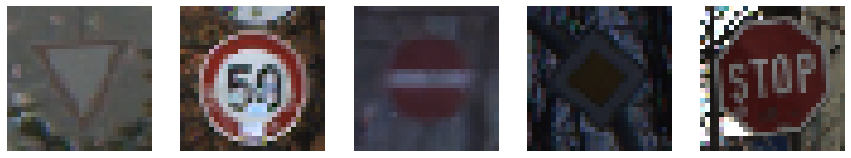

In [ ]:
f, axs = plt.subplots(1, 5, figsize=(15, 4))
for j in range(len(axs)):
    axs[j].imshow(x_train[j], cmap='binary')
    axs[j].axis('off')

# Model 3: Updated CNN Model

In [ ]:
def build_upd_cnn():
    
    # ********************************************** 48*48
    inpt = Input(shape=(30,30,3))
    conv1 = Conv2D(32, 3, 3,padding = 'same',kernel_initializer='he_normal')(inpt)
    norm1 = BatchNormalization(epsilon=1e-06, axis=3)(conv1)
    act1 =  Activation('relu')(norm1)
  
    conv2 = Conv2D(48, 7, 1, padding='same', kernel_initializer='he_normal')(act1)
    norm2 = BatchNormalization(epsilon=1e-06, axis=3)(conv2)
    act2 = Activation('relu')(norm2)
    conv3 = Conv2D(48, 1, 7, padding='same', kernel_initializer='he_normal')(act2)
    norm3 = BatchNormalization(epsilon=1e-06, axis=3)(conv3)
    act3 = Activation('relu')(norm3)   
    pool1 = MaxPool2D(pool_size=(2, 2), padding = 'same')(act3)
    drop1 = Dropout(0.2)(pool1)
    # ****************************************** 24*24
   
    conv4 = Conv2D(64, 3, 1, padding='same', kernel_initializer='he_normal')(drop1)
    norm4 = BatchNormalization(epsilon=1e-06, axis=3)(conv4)
    act4 = Activation('relu')(norm4)
    conv5 = Conv2D(64, 1, 3, padding='same', kernel_initializer='he_normal')(act4)
    norm5 = BatchNormalization(epsilon=1e-06, axis=3)(conv5)
    act5 = Activation('relu')(norm5)
    
    conv6 = Conv2D(64, 1, 7, padding='same', kernel_initializer='he_normal')(drop1)
    norm6 = BatchNormalization(epsilon=1e-06, axis=3)(conv6)
    act6 = Activation('relu')(norm6)
    conv7 = Conv2D(64, 7, 1, padding='same', kernel_initializer='he_normal')(act6)
    norm7 = BatchNormalization(epsilon=1e-06, axis=3)(conv7)
    act7 = Activation('relu')(norm7)    
    
    concat = concatenate([act5, act7])
    
    pool2 = MaxPool2D(pool_size=(2, 2), padding='same')(concat)
    drop2 = Dropout(0.2)(pool2)
    
    # ******************************************* 12*12
    conv8 = Conv2D(128, 3, 3, padding='same', kernel_initializer='he_normal')(drop2)
    norm8 = BatchNormalization(epsilon=1e-06, axis=3)(conv8)
    
    act8 = Activation('relu')(norm8)
    conv9 = Conv2D(256, 3, 3, padding='same', kernel_initializer='he_normal')(act8)   # 之前是256个滤波器
    norm9 = BatchNormalization(epsilon=1e-06, axis=3)(conv9)
    act9 = Activation('relu')(norm9)
    pool3 = MaxPool2D(pool_size=(2, 2), padding='same')(act9)
    drop3 = Dropout(0.3)(pool3)
    
    # *************************************** 6*6
    flat = Flatten()(drop3)
    dense1 = Dense(256, kernel_initializer='he_normal')(flat)
    norm10 = BatchNormalization()(dense1)
    act10 = Activation('relu')(norm10)
    drop4 = Dropout(0.4)(act10)
    output = Dense(43, activation='softmax', kernel_initializer='he_normal')(drop4)
    
    model = Model(inputs=inpt, outputs=output)
    
    adam = Adam(
        lr=0.001, decay=1e-6)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model_upd_cnn = build_upd_cnn()
model_upd_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 30, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 10, 10, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 10, 10, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 10, 10, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#training

# history_upd_cnn = model_upd_cnn.fit(
#       train_generator, batch_size=16,
#       validation_data = val_generator,  
#       epochs=30,
#       shuffle = True,
#       verbose=1)

history_upd_cnn = model_upd_cnn.fit(
      train_generator,
      validation_data = val_generator,  
      epochs=20,
      verbose=1)

Epoch 1/20
312/312 [==============================] - 30s 43ms/step - loss: 2.8128 - accuracy: 0.2355 - val_loss: 2.2820 - val_accuracy: 0.3248
Epoch 2/20
312/312 [==============================] - 13s 41ms/step - loss: 1.3502 - accuracy: 0.5731 - val_loss: 1.0987 - val_accuracy: 0.6546
Epoch 3/20
312/312 [==============================] - 13s 40ms/step - loss: 0.8733 - accuracy: 0.7220 - val_loss: 0.9010 - val_accuracy: 0.7296
Epoch 4/20
312/312 [==============================] - 13s 40ms/step - loss: 0.6550 - accuracy: 0.7947 - val_loss: 0.8096 - val_accuracy: 0.7602
Epoch 5/20
312/312 [==============================] - 13s 40ms/step - loss: 0.5444 - accuracy: 0.8310 - val_loss: 0.7281 - val_accuracy: 0.7894
Epoch 6/20
312/312 [==============================] - 12s 40ms/step - loss: 0.4573 - accuracy: 0.8609 - val_loss: 0.7423 - val_accuracy: 0.7920
Epoch 7/20
312/312 [==============================] - 13s 40ms/step - loss: 0.4010 - accuracy: 0.8790 - val_loss: 0.7131 - val_accuracy:

In [ ]:
#Save model
# model_upd_cnn.save("/content/gdrive/MyDrive/GTSRB/models/model3_3rdrun")
# model_upd_cnn.save("/content/gdrive/MyDrive/GTSRB/models/model3_3rdrun.h5")

#Load Model
from tensorflow.keras.models  import load_model
model_upd_cnn = load_model('/content/gdrive/MyDrive/GTSRB/models/model3_3rdrun85.32.h5',compile=False)

# Predict model accuracy on clean test images

In [ ]:
pred = np.argmax(model_upd_cnn.predict(X_test), axis=-1)
accuracy_score(y_test, pred)
#2nd run: 0.8513855898653998
#*3rd run: 0.8532858273950911

0.8532858273950911

# Adversarial Attack

In [ ]:
#Specify Classifier with ART Library
cnn_classifier = TensorFlowV2Classifier(model=model_upd_cnn, nb_classes=43, input_shape=(30,30,3), loss_object=CategoricalCrossentropy())

In [ ]:
# Take (5) clean images from the test set to be perturbed with different adversarial attacks
x_test_adversarial = X_test#[0:5]
y_test_adversarial = y_test#[0:5]
#print(x_test_adv.shape)

In [ ]:
#Get Model Prediction on Adversarial Images
prediction = model_upd_cnn.predict(x_test_adversarial)

In [ ]:
probability_pred_clean = np.max(prediction, axis=1)
class_pred_clean = np.argmax(prediction, axis=1)

In [ ]:
#Visualize Clean and Adversarial Images and Distance
def calculateDistance(img1, img2):
    return np.sum((img1-img2)**2)

In [ ]:
gradcam_explainer = GradCAM()

## Carlini-Wagner

In [ ]:
carlini_attack = CarliniL2Method(classifier = cnn_classifier, targeted=False)

In [ ]:
start = time.time()
x_test_carlini = carlini_attack.generate(x = x_test_adversarial)
end = time.time()

print(f"1. Runtime for generating cw images with Carlini Wagner is {end - start} second")

#Save generated images into pickle file
# with open('/content/gdrive/MyDrive/GTSRB/pickles/x_test_cw1000_model2.pk', 'wb') as handle:
#     pickle.dump(x_test_carlini, handle, protocol=pickle.HIGHEST_PROTOCOL)


1. Runtime for generating cw images with Carlini Wagner is 44.36039853096008 second


In [ ]:
start = time.time()
x_test_carlini = carlini_attack.generate(x = x_test_adversarial[5000:6000])
end = time.time()

print(f"2. Runtime for generating cw images with Carlini Wagner is {end - start} second")

#Save generated images into pickle file
with open('/content/gdrive/MyDrive/GTSRB/pickles/x_test_cw6000_model3.pk', 'wb') as handle:
    pickle.dump(x_test_carlini, handle, protocol=pickle.HIGHEST_PROTOCOL)


2. Runtime for generating cw images with Carlini Wagner is 9232.496127843857 second


In [ ]:
start = time.time()
x_test_carlini = carlini_attack.generate(x = x_test_adversarial[6000:7000])
end = time.time()

print(f"2. Runtime for generating cw images with Carlini Wagner is {end - start} second")

#Save generated images into pickle file
with open('/content/gdrive/MyDrive/GTSRB/pickles/x_test_cw7000_model3.pk', 'wb') as handle:
    pickle.dump(x_test_carlini, handle, protocol=pickle.HIGHEST_PROTOCOL)


2. Runtime for generating cw images with Carlini Wagner is 9062.37231516838 second


In [ ]:
start = time.time()
x_test_carlini = carlini_attack.generate(x = x_test_adversarial[7000:8000])
end = time.time()

print(f"2. Runtime for generating cw images with Carlini Wagner is {end - start} second")

#Save generated images into pickle file
with open('/content/gdrive/MyDrive/GTSRB/pickles/x_test_cw8000_model3.pk', 'wb') as handle:
    pickle.dump(x_test_carlini, handle, protocol=pickle.HIGHEST_PROTOCOL)


2. Runtime for generating cw images with Carlini Wagner is 8959.91487288475 second


In [ ]:
start = time.time()
x_test_carlini = carlini_attack.generate(x = x_test_adversarial[9000:10000])
end = time.time()

print(f"2. Runtime for generating cw images with Carlini Wagner is {end - start} second")

#Save generated images into pickle file
with open('/content/gdrive/MyDrive/GTSRB/pickles/x_test_cw10000_model3.pk', 'wb') as handle:
    pickle.dump(x_test_carlini, handle, protocol=pickle.HIGHEST_PROTOCOL)


2. Runtime for generating cw images with Carlini Wagner is 9095.901116609573 second


In [ ]:
start = time.time()
x_test_carlini = carlini_attack.generate(x = x_test_adversarial[10000:11000])
end = time.time()

print(f"2. Runtime for generating cw images with Carlini Wagner is {end - start} second")

#Save generated images into pickle file
with open('/content/gdrive/MyDrive/GTSRB/pickles/x_test_cw11000_model3.pk', 'wb') as handle:
    pickle.dump(x_test_carlini, handle, protocol=pickle.HIGHEST_PROTOCOL)


2. Runtime for generating cw images with Carlini Wagner is 9033.467645168304 second


In [ ]:
# Load pickled CW images
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 3/x_test_cw_model3.pk", "rb") as input_file:
  x_test_carlini = pickle.load(input_file)

x_test_carlini.shape

(12630, 30, 30, 3)

In [ ]:
# Predict model accuracy on CW images
pred_cw = np.argmax(model_upd_cnn.predict(x_test_carlini), axis=-1)
accuracy_score(y_test, pred_cw)
#0.8266825019794141

0.8266825019794141

In [ ]:
# Predict model accuracy on CW images from model1
# Load pickled CW images
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 1/x_test_cw_model1.pk", "rb") as input_file:
  x_test_carlini_model1 = pickle.load(input_file)

print(x_test_carlini_model1.shape)

# Predict model accuracy
pred_cw_model1 = np.argmax(model_upd_cnn.predict(x_test_carlini_model1), axis=-1)
accuracy_score(y_test, pred_cw_model1)

(12630, 30, 30, 3)


0.8007125890736342

In [ ]:
# Predict model accuracy on CW images from model2
# Load pickled CW images
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 2/x_test_cw_model2.pk", "rb") as input_file:
  x_test_carlini_model2 = pickle.load(input_file)

print(x_test_carlini_model2.shape)

# Predict model accuracy
pred_cw_model2 = np.argmax(model_upd_cnn.predict(x_test_carlini_model2), axis=-1)
accuracy_score(y_test, pred_cw_model2)

(12630, 30, 30, 3)


0.8098178939034046

IndexError: ignored

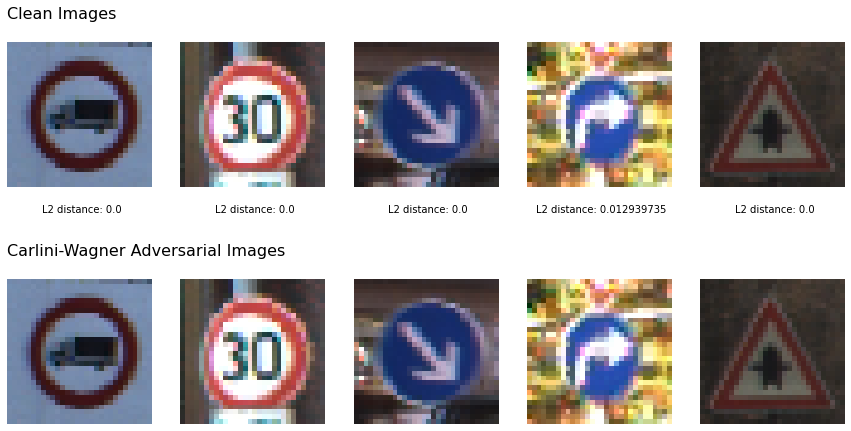

In [ ]:
f, axs = plt.subplots(2, 5, figsize=(15, 8))
distance = [calculateDistance(x1,x2) for x1,x2 in zip(x_test_adversarial, x_test_carlini)]
title = ['Clean Images', 'Carlini-Wagner Adversarial Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    
    axs[0, i].imshow(v, cmap='binary')
    axs[0, i].text(15, 35, 'L2 distance: '+ str(distance[i]), ha='center')
    axs[1, i].imshow(x_test_carlini[i], cmap='binary')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

In [ ]:
#Predict Updated CNN Accuracy on CW Images
y_pred_cw = model_upd_cnn(x_test_carlini)
y_pred_cw = np.argmax(y_pred_cw, axis=1)
acc = sum(1 for x,y in zip(y_pred_cw, y_test_adversarial) if x == y) / float(len(y_test_adversarial))
acc

0.8266825019794141

In [ ]:
#Calculate average L2 distance between clean vs CW images
sum = 0
for i in range(len(x_test_adversarial)):
  sum += calculateDistance(x_test_adversarial[i], x_test_carlini[i])

avgL2_cw = sum / len(x_test_adversarial)
print("Avg L2 distance of generated CW images: ", avgL2_cw)

Avg L2 distance of generated CW images:  0.3013923924489985


In [ ]:
#Get Model Prediction on Adversarial Images
prediction_cw = model_upd_cnn.predict(x_test_carlini)

probability_pred_cw = np.max(prediction_cw, axis=1)
class_pred_cw = np.argmax(prediction_cw, axis=1)

IndexError: ignored

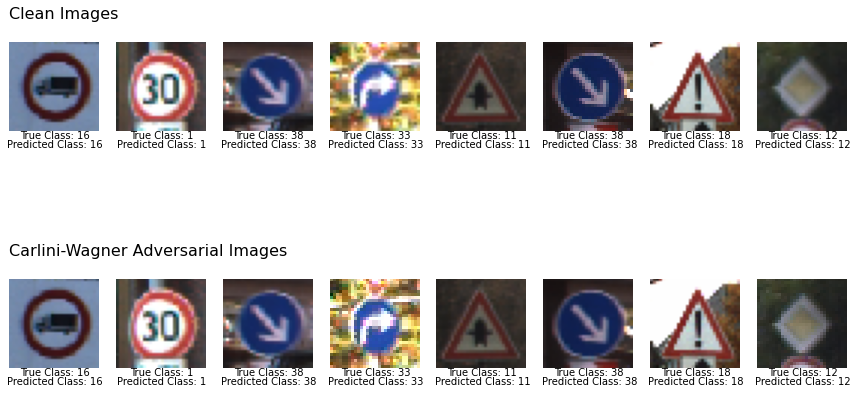

In [ ]:
f, axs = plt.subplots(2, 8, figsize=(15, 8))
distance = [calculateDistance(x1,x2) for x1,x2 in zip(x_test_adversarial, x_test_carlini)]
title = ['Clean Images', 'Carlini-Wagner Adversarial Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    
    axs[0, i].imshow(v, cmap='binary')
    axs[0, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, i].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')
    axs[1, i].imshow(x_test_carlini[i], cmap='binary')
    axs[1, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, i].text(15, 35, 'Predicted Class: '+ str(class_pred_cw[i]), ha='center')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

## Visualize Grad-CAM on Clean and Adversarial CW Images

/usr/local/lib/python3.7/dist-packages/tf_explain/utils/display.py:112: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())


IndexError: ignored

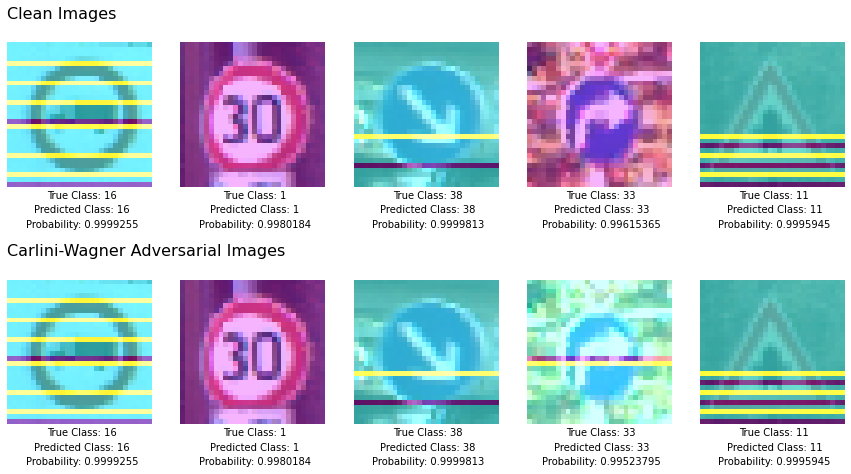

In [ ]:
f, axs = plt.subplots(2, 5, figsize=(15, 8))
title = ['Clean Images', 'Carlini-Wagner Adversarial Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    data_clean = ([v], None)
    data_adv = ([x_test_carlini[i]], None)
    explanation_clean = gradcam_explainer.explain(data_clean, model_upd_cnn, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    explanation_cw = gradcam_explainer.explain(data_adv, model_upd_cnn, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    
    axs[0, i].imshow(explanation_clean, cmap='binary')
    axs[0, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, i].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')
    axs[0, i].text(15, 38, 'Probability: '+ str(probability_pred_clean[i]), ha='center')
    axs[1, i].imshow(explanation_cw, cmap='binary')
    axs[1, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, i].text(15, 35, 'Predicted Class: '+ str(class_pred_cw[i]), ha='center')
    axs[1, i].text(15, 38, 'Probability: '+ str(probability_pred_cw[i]), ha='center')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

/usr/local/lib/python3.7/dist-packages/tf_explain/utils/display.py:112: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())


IndexError: ignored

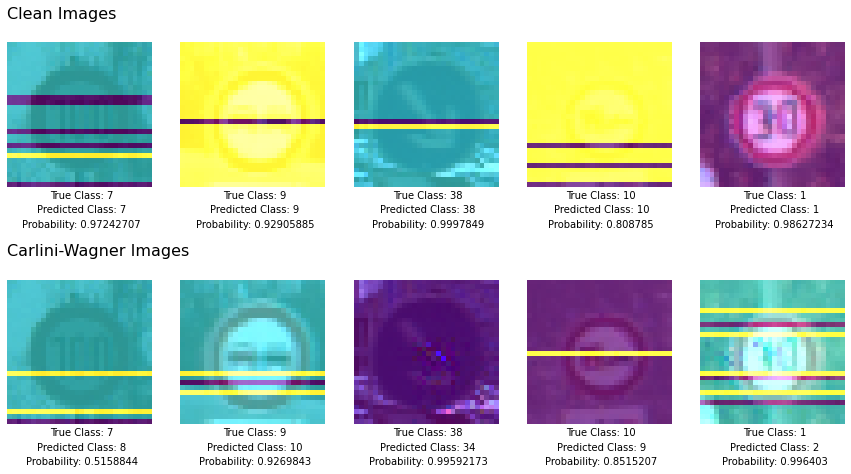

In [ ]:
#Visualize successful attacks

f, axs = plt.subplots(2, 5, figsize=(15, 8))
title = ['Clean Images', 'Carlini-Wagner Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
  
a=0
for i,v in enumerate(x_test_adversarial):
  if (y_test_adversarial[i] == class_pred_clean[i]) and (y_test_adversarial[i] != class_pred_cw[i]):
    data_clean = ([v], None)
    data_adv = ([x_test_carlini[i]], None)
    explanation_clean = gradcam_explainer.explain(data_clean, model_upd_cnn, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    explanation_cw = gradcam_explainer.explain(data_adv, model_upd_cnn, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    
    axs[0, a].imshow(explanation_clean, cmap='binary')
    axs[0, a].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, a].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')
    axs[0, a].text(15, 38, 'Probability: '+ str(probability_pred_clean[i]), ha='center')
    axs[1, a].imshow(explanation_cw, cmap='binary')
    axs[1, a].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, a].text(15, 35, 'Predicted Class: '+ str(class_pred_cw[i]), ha='center')
    axs[1, a].text(15, 38, 'Probability: '+ str(probability_pred_cw[i]), ha='center')
    axs[0, a].axis('off')
    axs[1, a].axis('off')
    a += 1
  else:
    i += 1
    v += 1

In [ ]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

IndexError: ignored

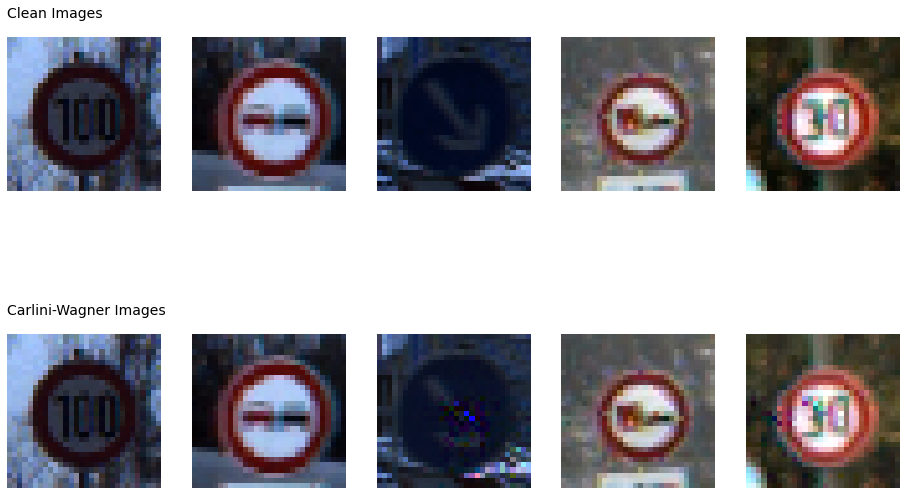

In [ ]:
#Visualize Clean, Perturbed Added, and Adversarial Images on Successfull Attack

f, axs = plt.subplots(2, 5, figsize=(16, 10))
title = ['Clean Images', 'Carlini-Wagner Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=14, pad = 0)
    
a = 0

for i,v in enumerate(x_test_adversarial):
  if (y_test_adversarial[i] == class_pred_clean[i]) and (y_test_adversarial[i] != class_pred_cw[i]):
    
    #axs[0, a].imshow( ((v/v.max())*255).astype(np.uint8), cmap='binary')
    axs[0, a].imshow( NormalizeData(v), cmap='binary')
    # print("vmin: ", v.min()) 0.0
    # print("vmax: ", v.max()) 6.6313725
    # print("tempImgmin: ", tempImg.min()) -0.12703179
    # print("tempImgmax: ", tempImg.max()) 6.0519924
    #axs[1, a].imshow( NormalizeData(v) - NormalizeData(x_test_carlini[i]) , cmap='binary')
    axs[1, a].imshow( NormalizeData(x_test_carlini[i]), cmap='binary')
    axs[0, a].axis('off')
    axs[1, a].axis('off')
    #axs[2, a].axis('off')
    a += 1
  else:
    i += 1
    v += 1

## JSMA

In [ ]:
jsma_attack = SaliencyMapMethod(classifier = cnn_classifier, theta=0.1, gamma=0.01)

In [ ]:
start = time.time()
x_test_jsma = jsma_attack.generate(x = x_test_adversarial)
end = time.time()

print(f"Runtime for generating adv images with JSMA is {end - start} second")

#Save generated images into pickle file
with open('/content/gdrive/MyDrive/GTSRB/pickles/x_test_jsma_model3_gamma.01.pk', 'wb') as handle:
    pickle.dump(x_test_jsma, handle, protocol=pickle.HIGHEST_PROTOCOL)


Runtime for generating adv images with JSMA is 15120.619260549545 second


In [ ]:
#Load pickled JSMA images
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 3/x_test_jsma_model3_gamma.01.pk", "rb") as input_file:
  x_test_jsma = pickle.load(input_file)

In [ ]:
# Predict model accuracy on JSMA test images
pred_jsma = np.argmax(model_upd_cnn.predict(x_test_jsma), axis=-1)
accuracy_score(y_test, pred_jsma)
#0.1529
#*0.693507521773555

0.693507521773555

In [ ]:
#Predict model accuracy on JSMA images for model 1
#Load pickled JSMA images for model 1
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 1/x_test_jsma_model1_gamma.01.pk", "rb") as input_file:
  x_test_jsma_model1 = pickle.load(input_file)

# Predict model accuracy on JSMA test images for model 2
pred_jsma_model1 = np.argmax(model_upd_cnn.predict(x_test_jsma_model1), axis=-1)
accuracy_score(y_test, pred_jsma_model1)

0.6535233570863025

In [ ]:
#Predict model accuracy on JSMA images for model 2
#Load pickled JSMA images for model 2
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 2/x_test_jsma_model2_gamma.01.pk", "rb") as input_file:
  x_test_jsma_model2 = pickle.load(input_file)

# Predict model accuracy on JSMA test images for model 2
pred_jsma_model2 = np.argmax(model_upd_cnn.predict(x_test_jsma_model2), axis=-1)
accuracy_score(y_test, pred_jsma_model2)

0.6411718131433096

In [ ]:
#Calculate average L2 distance between clean vs JSMA images
sum = 0
for i in range(len(x_test_adversarial)):
  sum += calculateDistance(x_test_adversarial[i], x_test_jsma[i])

avgL2_jsma = sum / len(x_test_adversarial)
print("Avg L2 distance of generated JSMA images: ", avgL2_jsma)
#Avg L2 distance of generated JSMA images:  72.61104308526376
#*Avg L2 distance of generated JSMA images:  2.4773304320290768

Avg L2 distance of generated JSMA images:  2.4773304320290768


## Visualize Clean and JSMA Images and Distance

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: ignored

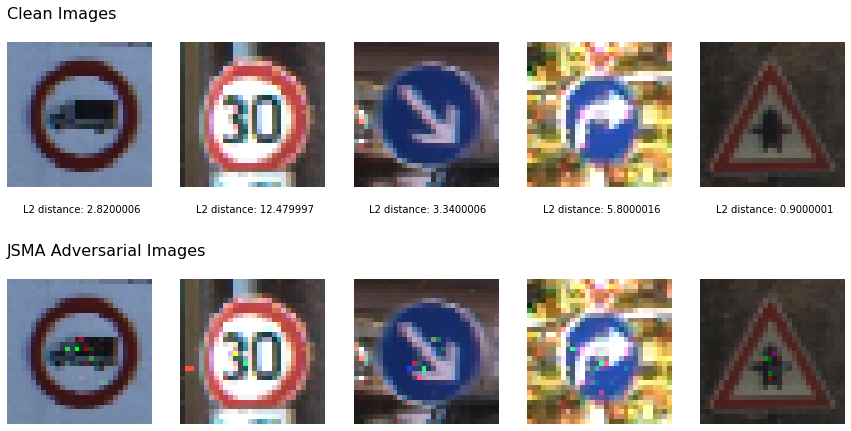

In [ ]:
f, axs = plt.subplots(2, 5, figsize=(15, 8))
distance = [calculateDistance(x1,x2) for x1,x2 in zip(x_test_adversarial, x_test_jsma)]
title = ['Clean Images', 'JSMA Adversarial Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    
    axs[0, i].imshow(v, cmap='binary')
    axs[0, i].text(15, 35, 'L2 distance: '+ str(distance[i]), ha='center')
    axs[1, i].imshow(x_test_jsma[i], cmap='binary')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

In [ ]:
#Predict CNN Accuracy on JSMA Images
y_pred_jsma = model_upd_cnn(x_test_jsma)
y_pred_jsma = np.argmax(y_pred_jsma, axis=1)
acc = sum(1 for x,y in zip(y_pred_jsma, y_test_adversarial) if x == y) / float(len(y_test_adversarial))
acc

TypeError: ignored

In [ ]:
#Get Model Prediction on Adversarial Images
prediction_jsma = model_upd_cnn.predict(x_test_jsma)

probability_pred_jsma = np.max(prediction_jsma, axis=1)
class_pred_jsma = np.argmax(prediction_jsma, axis=1)

In [ ]:
#Calculate average L2 distance between clean vs JSMA images
sum = 0
for i in range(len(X_test)):
  sum += calculateDistance(X_test[i], x_test_jsma[i])

avgL2_jsma = sum / len(X_test)
print("Avg L2 distance of generated JSMA images: ", avgL2_jsma)

Avg L2 distance of generated JSMA images:  2.4773304320290768


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: ignored

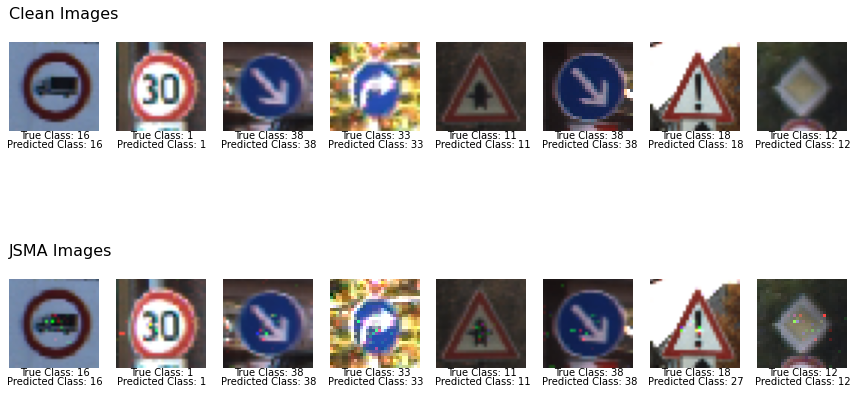

In [ ]:
f, axs = plt.subplots(2, 8, figsize=(15, 8))
distance = [calculateDistance(x1,x2) for x1,x2 in zip(x_test_adversarial, x_test_carlini)]
title = ['Clean Images', 'JSMA Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    
    axs[0, i].imshow(v, cmap='binary')
    axs[0, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, i].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')
    axs[1, i].imshow(x_test_jsma[i], cmap='binary')
    axs[1, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, i].text(15, 35, 'Predicted Class: '+ str(class_pred_jsma[i]), ha='center')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

## Visualize Grad-CAM on Clean and JSMA Images

/usr/local/lib/python3.7/dist-packages/tf_explain/utils/display.py:112: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())


IndexError: ignored

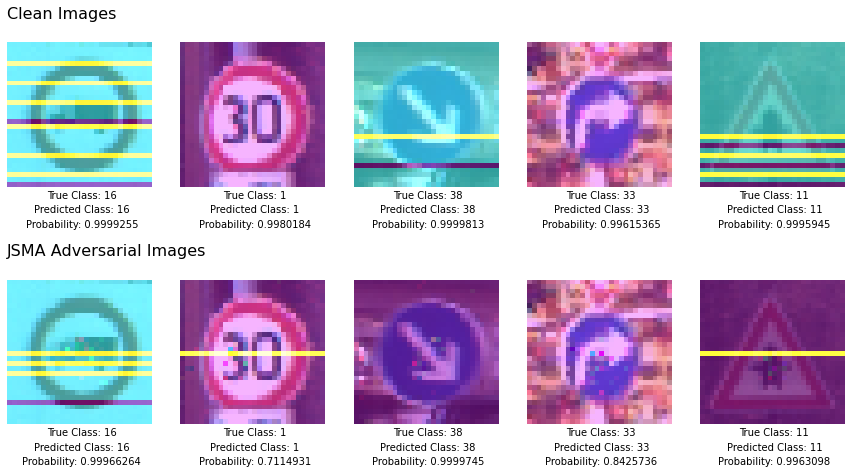

In [ ]:
f, axs = plt.subplots(2, 5, figsize=(15, 8))
title = ['Clean Images', 'JSMA Adversarial Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    data_clean = ([v], None)
    data_adv = ([x_test_jsma[i]], None)
    explanation_clean = gradcam_explainer.explain(data_clean, model_upd_cnn, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    explanation_jsma = gradcam_explainer.explain(data_adv, model_upd_cnn, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    
    axs[0, i].imshow(explanation_clean, cmap='binary')
    axs[0, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, i].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')
    axs[0, i].text(15, 38, 'Probability: '+ str(probability_pred_clean[i]), ha='center')
    axs[1, i].imshow(explanation_jsma, cmap='binary')
    axs[1, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, i].text(15, 35, 'Predicted Class: '+ str(class_pred_jsma[i]), ha='center')
    axs[1, i].text(15, 38, 'Probability: '+ str(probability_pred_jsma[i]), ha='center')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

/usr/local/lib/python3.7/dist-packages/tf_explain/utils/display.py:112: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())


IndexError: ignored

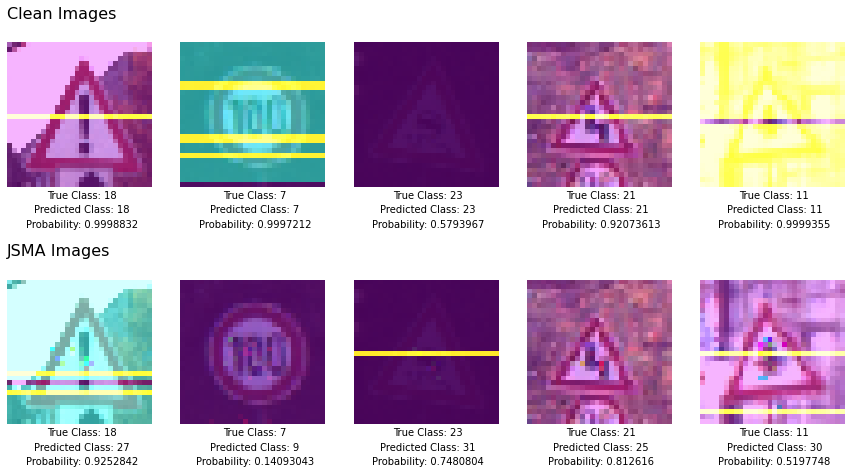

In [ ]:
#Visualize successful attacks

f, axs = plt.subplots(2, 5, figsize=(15, 8))
title = ['Clean Images', 'JSMA Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
  
a=0
for i,v in enumerate(x_test_adversarial):
  if (y_test_adversarial[i] == class_pred_clean[i]) and (y_test_adversarial[i] != class_pred_jsma[i]):
    data_clean = ([v], None)
    data_adv = ([x_test_jsma[i]], None)
    explanation_clean = gradcam_explainer.explain(data_clean, model_upd_cnn, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    explanation_jsma = gradcam_explainer.explain(data_adv, model_upd_cnn, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    
    axs[0, a].imshow(explanation_clean, cmap='binary')
    axs[0, a].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, a].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')
    axs[0, a].text(15, 38, 'Probability: '+ str(probability_pred_clean[i]), ha='center')
    axs[1, a].imshow(explanation_jsma, cmap='binary')
    axs[1, a].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, a].text(15, 35, 'Predicted Class: '+ str(class_pred_jsma[i]), ha='center')
    axs[1, a].text(15, 38, 'Probability: '+ str(probability_pred_jsma[i]), ha='center')
    axs[0, a].axis('off')
    axs[1, a].axis('off')
    a += 1
  else:
    i += 1
    v += 1

6
11
12
16
25


IndexError: ignored

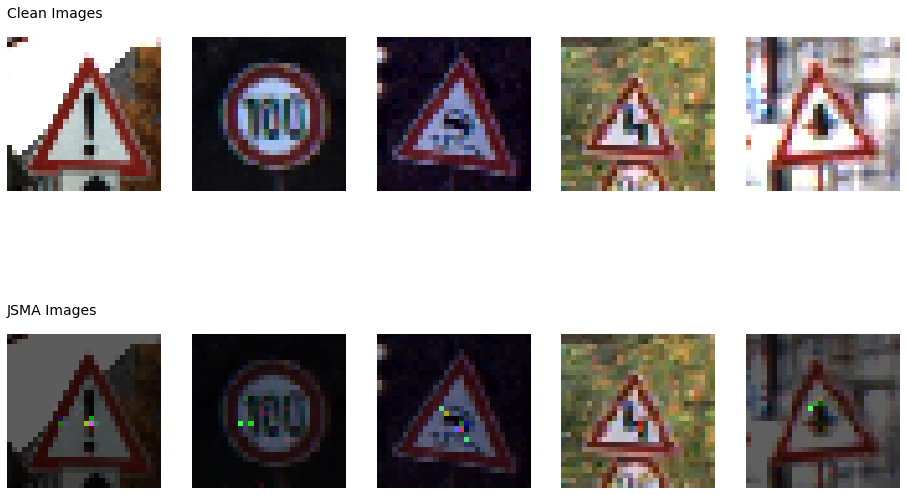

In [ ]:
#Visualize Clean, Perturbed Added, and Adversarial Images on Successfull Attack

f, axs = plt.subplots(2, 5, figsize=(16, 10))
title = ['Clean Images', 'JSMA Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=14, pad = 0)
    
a = 0

for i,v in enumerate(x_test_adversarial):
  if (y_test_adversarial[i] == class_pred_clean[i]) and (y_test_adversarial[i] != class_pred_jsma[i]):
    
    axs[0, a].imshow(NormalizeData(v), cmap='binary')
    axs[1, a].imshow(NormalizeData(x_test_jsma[i]), cmap='binary')
    #axs[2, a].imshow((x_test_jsma[i]*255).astype(np.uint8), cmap='binary')
    axs[0, a].axis('off')
    axs[1, a].axis('off')
    #axs[2, a].axis('off')
    a += 1
    print(i)
  else:
    i += 1
    v += 1

## DeepFool

In [ ]:
df_attack = DeepFool(classifier= cnn_classifier)

In [ ]:
start = time.time()
x_test_df = df_attack.generate(x=x_test_adversarial)
end = time.time()

print(f"Runtime for generating adv images with DeepFool is {end - start} second")

#Save generated images into pickle file
with open('/content/gdrive/MyDrive/GTSRB/pickles/x_test_df_model3.pk', 'wb') as handle:
    pickle.dump(x_test_df, handle, protocol=pickle.HIGHEST_PROTOCOL)


Runtime for generating adv images with DeepFool is 38622.276547670364 second


In [ ]:
start = time.time()
x_test_df = df_attack.generate(x=x_test_adversarial)
end = time.time()

print(f"Runtime for generating adv images with DeepFool is {end - start} second")

#Save generated images into pickle file
with open('/content/gdrive/MyDrive/GTSRB/pickles/x_test_df_model3_2ndrun.pk', 'wb') as handle:
    pickle.dump(x_test_df, handle, protocol=pickle.HIGHEST_PROTOCOL)


Runtime for generating adv images with DeepFool is 39958.01313281059 second


In [ ]:
#Load pickled DeepFool images
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 3/x_test_df_model3.pk", "rb") as input_file:
  x_test_df = pickle.load(input_file)

In [ ]:
# Predict model accuracy on DeepFool test images
pred_df = np.argmax(model_upd_cnn.predict(x_test_df), axis=-1)
accuracy_score(y_test, pred_df)
#0.17347585114806016

0.17347585114806016

In [ ]:
#Predict model accuracy on DF images for model 1
#Load pickled DF images for model 1
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 1/x_test_df_model1.pk", "rb") as input_file:
  x_test_df_model1 = pickle.load(input_file)

# Predict model accuracy on JSMA test images for model 1
pred_df_model1 = np.argmax(model_upd_cnn.predict(x_test_df_model1), axis=-1)
accuracy_score(y_test, pred_df_model1)

0.7844022169437846

In [ ]:
#Predict model accuracy on DF images for model 2
#Load pickled DF images for model 2
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 2/x_test_df_model2.pk", "rb") as input_file:
  x_test_df_model2 = pickle.load(input_file)

# Predict model accuracy on JSMA test images for model 2
pred_df_model2 = np.argmax(model_upd_cnn.predict(x_test_df_model2), axis=-1)
accuracy_score(y_test, pred_df_model2)

0.7800475059382422

In [ ]:
#Calculate average L2 distance between clean vs JSMA images
sum = 0
for i in range(len(x_test_adversarial)):
  sum += calculateDistance(x_test_adversarial[i], x_test_df[i])

avgL2_df = sum / len(x_test_adversarial)
print("Avg L2 distance of generated JSMA images: ", avgL2_df)
#249691.90
#279035.77459757816
#*249691.90359005408

Avg L2 distance of generated JSMA images:  249691.90359005408


## Visualize Clean and DeepFool Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: ignored

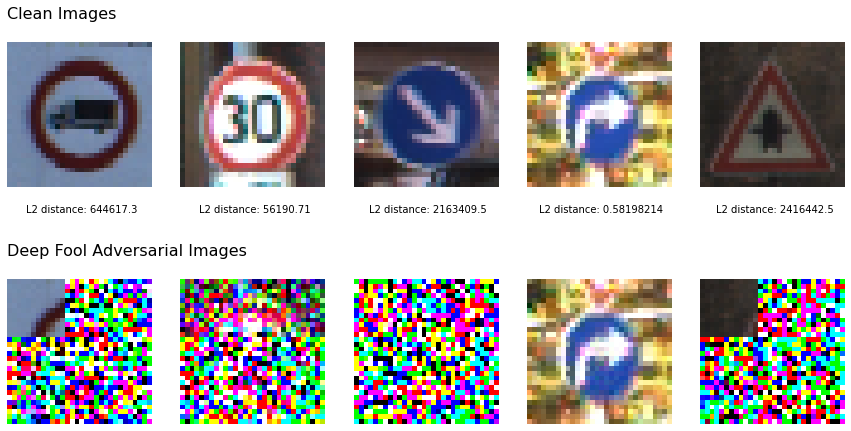

In [ ]:
f, axs = plt.subplots(2, 5, figsize=(15, 8))
distance = [calculateDistance(x1,x2) for x1,x2 in zip(x_test_adversarial, x_test_df)]
title = ['Clean Images', 'Deep Fool Adversarial Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    
    axs[0, i].imshow(v, cmap='binary')
    axs[0, i].text(15, 35, 'L2 distance: '+ str(distance[i]), ha='center')
    axs[1, i].imshow(x_test_df[i], cmap='binary')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

In [ ]:
#Predict CNN Accuracy on Adversarial Images Deep Fool
y_pred_df = model_upd_cnn(x_test_df)
y_pred_df = np.argmax(y_pred_df, axis=1)
acc = sum(1 for x,y in zip(y_pred_df, y_test_adversarial) if x == y) / float(len(y_test_adversarial))
acc

TypeError: ignored

In [ ]:
#Get Model Prediction on Adversarial Images
prediction_df = model_upd_cnn.predict(x_test_df)

probability_pred_df = np.max(prediction_df, axis=1)
class_pred_df = np.argmax(prediction_df, axis=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: ignored

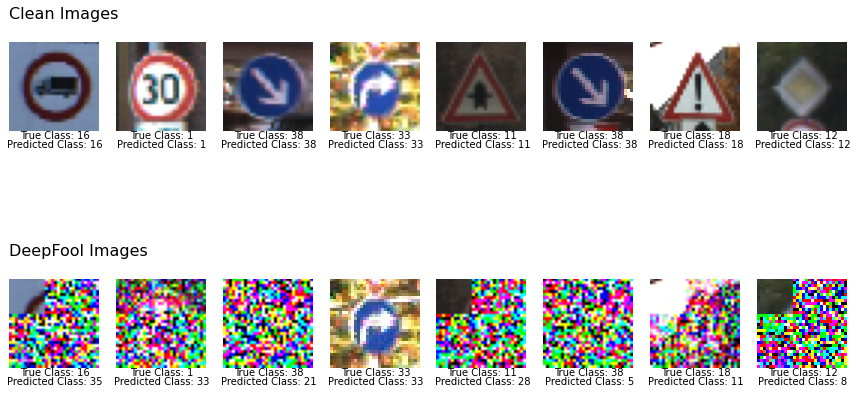

In [ ]:
f, axs = plt.subplots(2, 8, figsize=(15, 8))
#distance = [calculateDistance(x1,x2) for x1,x2 in zip(x_test_adversarial, x_test_carlini)]
title = ['Clean Images', 'DeepFool Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    
    axs[0, i].imshow(v, cmap='binary')
    axs[0, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, i].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')
    axs[1, i].imshow(x_test_df[i], cmap='binary')
    axs[1, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, i].text(15, 35, 'Predicted Class: '+ str(class_pred_df[i]), ha='center')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

## Visualize Grad-CAM on Clean and DeepFool Images

/usr/local/lib/python3.7/dist-packages/tf_explain/utils/display.py:112: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())


IndexError: ignored

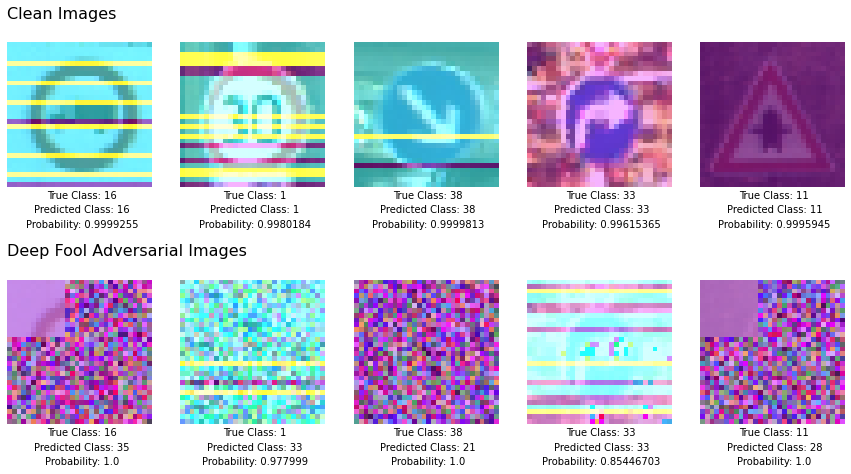

In [ ]:
f, axs = plt.subplots(2, 5, figsize=(15, 8))
title = ['Clean Images', 'Deep Fool Adversarial Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    data_clean = ([v], None)
    data_adv = ([x_test_df[i]], None)
    explanation_clean = gradcam_explainer.explain(data_clean, model_upd_cnn, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    explanation_df = gradcam_explainer.explain(data_adv, model_upd_cnn, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    
    axs[0, i].imshow(explanation_clean, cmap='binary')
    axs[0, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, i].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')
    axs[0, i].text(15, 38, 'Probability: '+ str(probability_pred_clean[i]), ha='center')
    axs[1, i].imshow(explanation_df, cmap='binary')
    axs[1, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, i].text(15, 35, 'Predicted Class: '+ str(class_pred_df[i]), ha='center')
    axs[1, i].text(15, 38, 'Probability: '+ str(probability_pred_df[i]), ha='center')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

0
1
2
4
5


IndexError: ignored

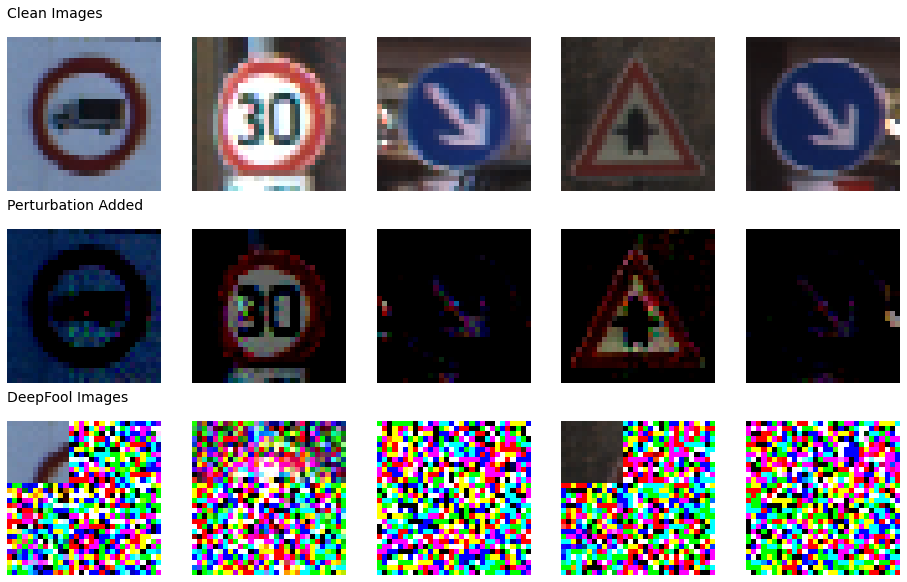

In [ ]:
#Visualize Clean, Perturbed Added, and Adversarial Images on Successfull Attack

f, axs = plt.subplots(3, 5, figsize=(16, 10))
title = ['Clean Images', 'Perturbation Added', 'DeepFool Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=14, pad = 0)
    
a = 0

for i,v in enumerate(x_test_adversarial):
  if (y_test_adversarial[i] == class_pred_clean[i]) and (y_test_adversarial[i] != class_pred_df[i]):
    
    axs[0, a].imshow(v, cmap='binary')
    axs[1, a].imshow(NormalizeData(v)-NormalizeData(x_test_df[i]), cmap='binary')
    axs[2, a].imshow(x_test_df[i], cmap='binary')
    axs[0, a].axis('off')
    axs[1, a].axis('off')
    axs[2, a].axis('off')
    a += 1
    print(i)
  else:
    i += 1
    v += 1